In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import seawater as sw
from seawater.library import T90conv
from scipy import stats
import matplotlib.colors as colors



#### Open FG CO2 mean over 5th IAF cycle 

#### No GCB run

In [2]:
case = 'cesm22cocco.G1850ECOIAF.T62_g17.003'
user = 'kristenk'
path = '/glade/campaign/cgd/oce/projects/besome/cesm-cases/' + case + '/ocn/proc/tseries/month_1'

In [3]:
variables = ['FG_ALT_CO2','FG_CO2'] 

In [4]:
%%time
ds_list = []
print(f'reading {case}')
ds = xr.Dataset()

for v in variables:
    
    print(v)
    
    files = sorted(glob(f'{path}/{case}.pop.h.{v}.024901-031012.nc'))       
    #files = sorted(glob(f'{path}/{case}.pop.h.{v}.012501-018612.nc'))   
    
    
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True, chunks={'z_t' : 1})

    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading cesm22cocco.G1850ECOIAF.T62_g17.003
FG_ALT_CO2
FG_CO2
CPU times: user 678 ms, sys: 80.6 ms, total: 759 ms
Wall time: 1.25 s


In [5]:
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','time_bound','TAREA','REGION_MASK'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']
cesm_mon_ds = ds.drop([v for v in ds.variables if v not in keep_vars])

In [6]:
cesm_ann_ds=cesm_mon_ds.mean(dim='time').compute()

#### 2x GCB run

In [7]:
case = 'cesm22cocco.G1850ECOIAF.T62_g17.004'
user = 'kristenk'
path = '/glade/campaign/cgd/oce/projects/besome/cesm-cases/' + case + '/ocn/proc/tseries/month_1'
variables = ['FG_ALT_CO2'] 

In [8]:
%%time
ds_list = []
print(f'reading {case}')
ds = xr.Dataset()

for v in variables:
    
    print(v)
    
    files = sorted(glob(f'{path}/{case}.pop.h.{v}.024901-031012.nc'))       
    #files = sorted(glob(f'{path}/{case}.pop.h.{v}.012501-018612.nc'))   
    
    
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True, chunks={'z_t' : 1})

    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading cesm22cocco.G1850ECOIAF.T62_g17.004
FG_ALT_CO2
CPU times: user 71 ms, sys: 5.41 ms, total: 76.5 ms
Wall time: 283 ms


In [9]:
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','time_bound','TAREA','REGION_MASK'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']
cesm_mon_ds2x = ds.drop([v for v in ds.variables if v not in keep_vars])

In [10]:
cesm_ann_ds2x=cesm_mon_ds2x.mean(dim='time').compute()

In [11]:
#write out annual means
outfile='/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.003/ocn/proc/mean5thIAF/annual_mean_gasflux.nc'
cesm_ann_ds.to_netcdf(outfile)

In [12]:
#write out annual means
outfile2='/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.004/ocn/proc/mean5thIAF/annual_mean_gasflux.nc'
cesm_ann_ds2x.to_netcdf(outfile2)

In [13]:
#cesm_ann_ds=xr.open_dataset(outfile,decode_times=False,decode_coords=False)
#cesm_ann_ds2x=xr.open_dataset(outfile2,decode_times=False,decode_coords=False)

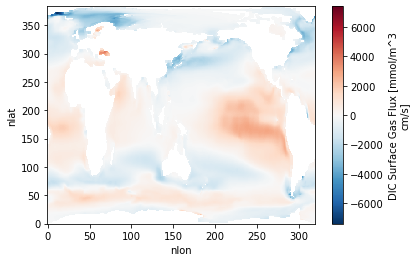

In [14]:
convert = 0.01 * 86400. * 365. * -1.
(cesm_ann_ds.FG_CO2 * convert).plot()

### Define a few plotting functions

In [15]:
def canvas_map_contour_overlay(lon,lat,z,
                               contour_specs,
                               units,
                               fig,
                               gridspec,
                               row,col):
    #-- make masked
    z = np.ma.masked_invalid(z)
    
    #-- make canvas
    ax = fig.add_subplot(gridspec[row,col],projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_global()

    #-- make filled contours
    cf = ax.contourf(lon,lat,z,
                     transform=ccrs.PlateCarree(),cmap='bwr',extend='both',**contour_specs
                     )
    #-- rasterize
    zorder = 0
    for contour_level in cf.collections:
        contour_level.set_zorder(zorder)
        contour_level.set_rasterized(True)

    #-- add contour lines
    cs = ax.contour(lon,lat,z,
                    colors='k',
                    levels = contour_specs['levels'],
                    linewidths = 0.5,
                    transform=ccrs.PlateCarree(),
                    zorder=len(cf.collections)+10)
    fmt = '%r'
    #-- add contour labels
    lb = plt.clabel(cs, fontsize=8,
                   inline = True,
                   fmt=fmt)

    #-- add land mask
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical','land','110m',
                                            edgecolor='face',
                                            facecolor='black'))

    #-- add colorbar
    i = 0
    while True:
        i += 1
        try:
            gridspec[i]
        except:
            break
    len_gs = i
    if len_gs == 1:
        shrink_factor = 0.75
    else:
        shrink_factor = 0.75

    cb = fig.colorbar(cf,ax = ax,
                      ticks = contour_specs['levels'],
                      orientation = 'vertical',
                      shrink = shrink_factor)
    cb.ax.set_title(units)
    cb.ax.tick_params(labelsize=9) 

    return {'ax':ax,'cf':cf,'cs':cs,'lb':lb,'cb':cb}

In [16]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

#### Define plotting coords with WOA on POP grid
#### (doesn't have the nans in the coords)

In [17]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2013_POPgrid.nc' 
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)
ds_woa['z_t'] = cesm_ann_ds.z_t

In [18]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
depths=ds_woa.z_t * 0.01

In [19]:
cesm_ann_ds

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60)
Coordinates:
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... nan nan nan
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... nan nan nan
  * z_t          (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    KMT          (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    REGION_MASK  (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    dz           (z_t) float32 1000.0 1000.0 1000.0 ... 24996.244 24998.11
    TAREA        (nlat, nlon) float64 1.125e+13 1.125e+13 1.124e+13 ... nan nan
    FG_ALT_CO2   (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan
    FG_CO2       (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan

In [20]:
diff_fg_co2 = (-1. * cesm_ann_ds.FG_ALT_CO2) - (-1* cesm_ann_ds.FG_CO2)
diff_fg_co2_2x = (-1. * cesm_ann_ds2x.FG_ALT_CO2) - (-1* cesm_ann_ds.FG_CO2)

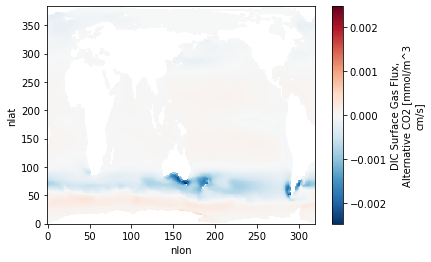

In [21]:
diff_fg_co2.plot()

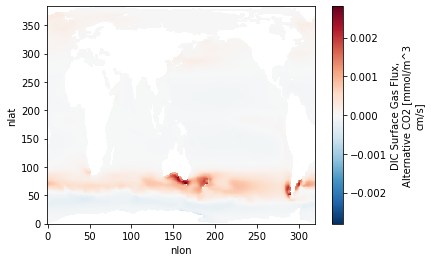

In [22]:
diff_fg_co2_2x.plot()

In [23]:
#convert mmol/m3*cm/sec to mmol/m2/yr
convert = 0.01 * 86400. * 365.
diff_fg_co2 = diff_fg_co2 * convert
diff_fg_co2_2x = diff_fg_co2_2x * convert

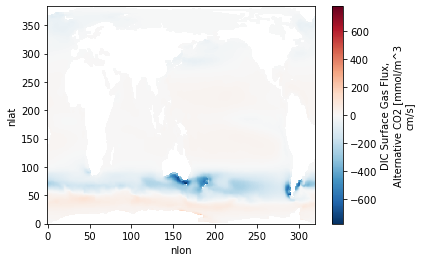

In [24]:
diff_fg_co2.plot()

In [25]:
levels = [-200.,-150.,-100.,-50.,-25.,-10.,-5.,0.,5.,10.,25.,50., 100.,  150.,  200.]

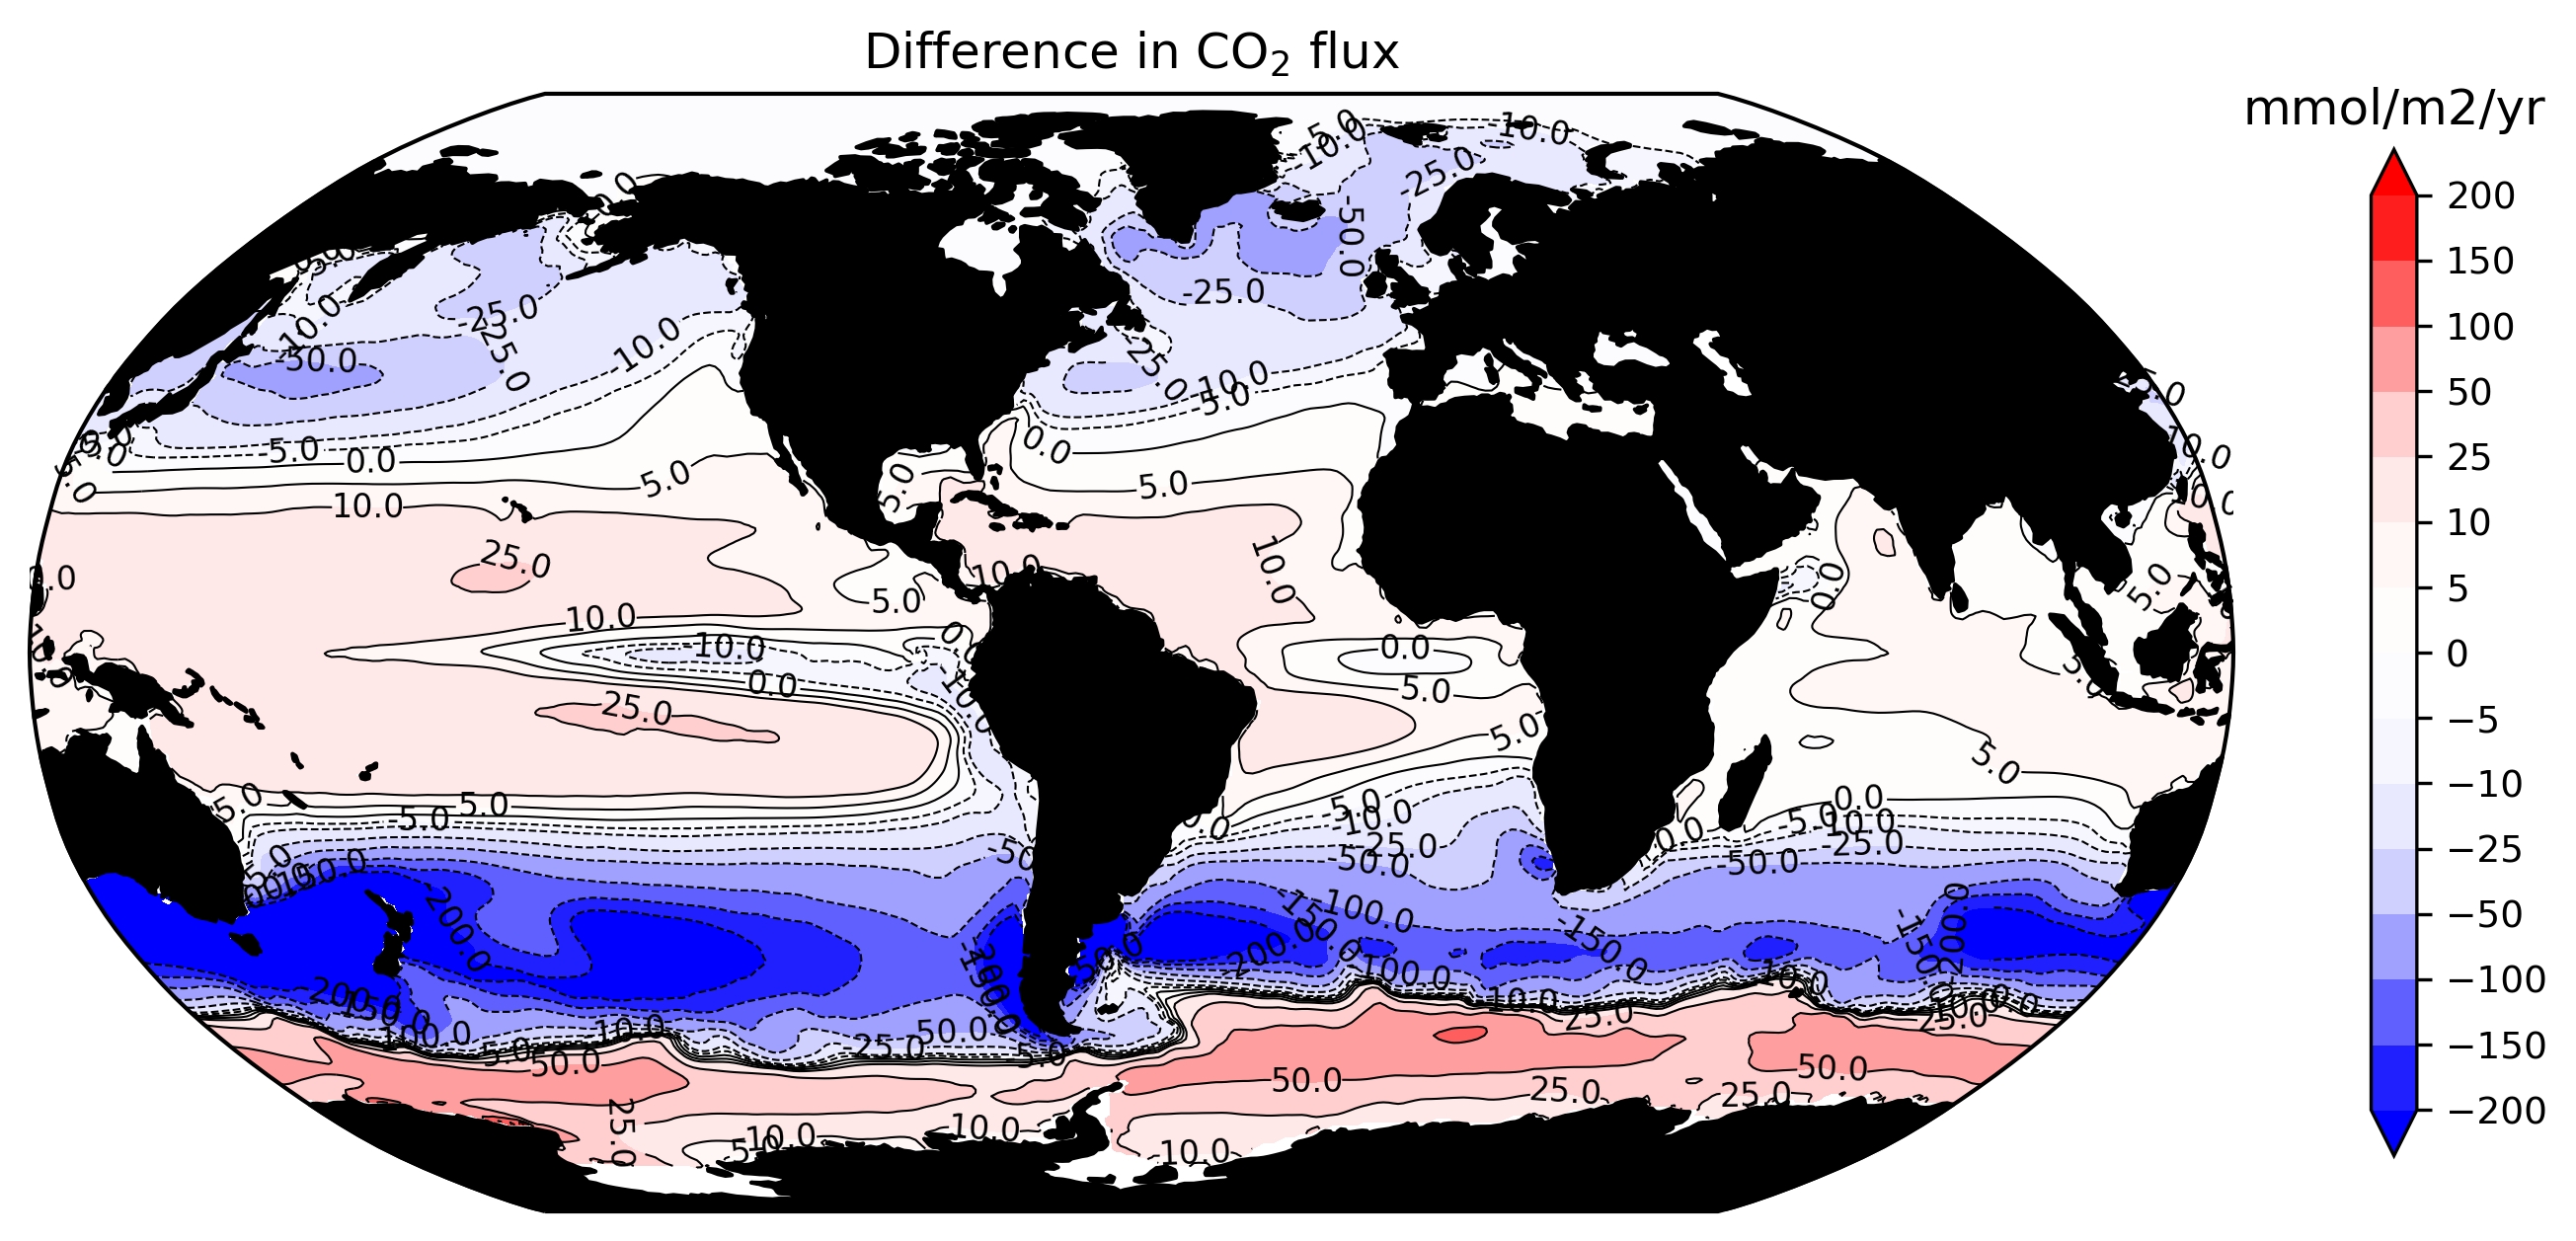

In [26]:
m={}
units = 'mmol/m2/yr'
plot_name = 'Difference in CO$_2$ flux'
var='sigma'
field = diff_fg_co2
lon,lat,field = adjust_pop_grid(lons,lats,field)

#contour_specs = {'levels': np.around(np.arange(-350., 351., 50.),decimals=1)}
contour_specs = {'levels': levels}
fig=plt.figure(figsize=(12, 6),dpi=300)
gs = gridspec.GridSpec(1,1)

m[var] = canvas_map_contour_overlay(lon,lat,field,
                                    contour_specs,
                                    units = units,
                                    fig=fig,
                                    gridspec=gs,
                                    row=0,col=0)
m[var]['ax'].set_title(plot_name);

#fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/fg_co2_diff.png', bbox_inches='tight', dpi=600)

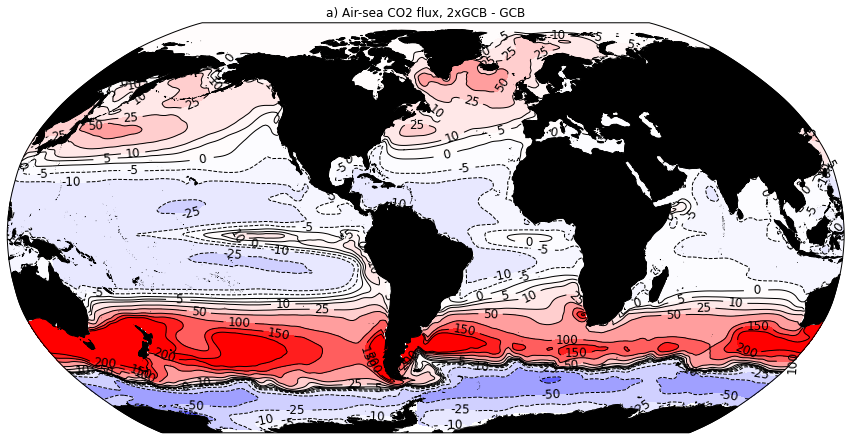

In [27]:
fig = plt.figure(figsize=(15,8))

contour_specs = {'levels': [-200.,-150.,-100.,-50.,-25.,-10.,-5.,0.,5.,10.,25.,50., 100.,  150.,  200.]}

######### CaCO3 surf CESM

lon,lat,field = adjust_pop_grid(lons,lats,diff_fg_co2_2x)
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('10m',linewidth=0.5)
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='bwr',extend='both',**contour_specs)

land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
                                            edgecolor='black',
                                            facecolor='black'))
ax.set_title('a) Air-sea CO2 flux, 2xGCB - GCB')

#overlay sigma contours
cs = ax.contour(lon,lat,field,
                colors='black',
                levels = contour_specs['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
plt.clabel(cs, colors = 'black', fmt = '%2.0f', fontsize=12);



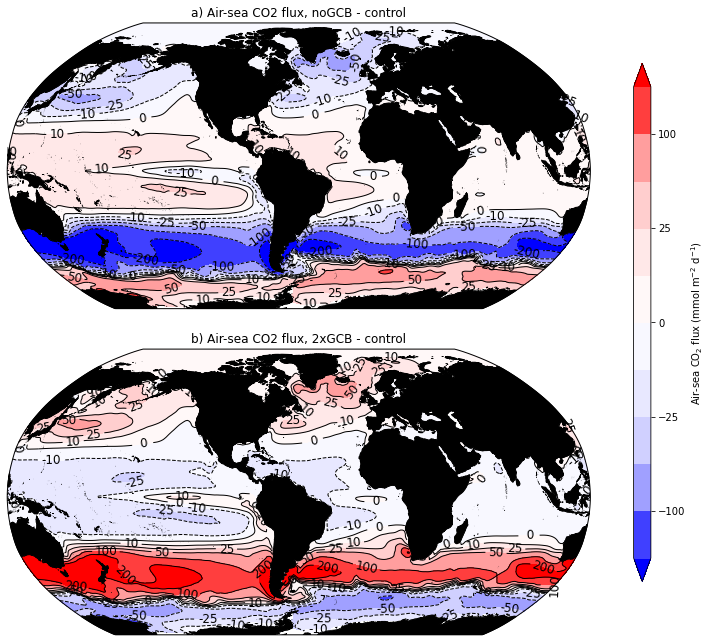

In [28]:
fig = plt.figure(figsize=(12,12))
contour_specs = {'levels': [-200.,-100.,-50.,-25.,-10.,0.,10.,25.,50., 100.,  200.]}

######### Difference in CO2 air-sea flux with NOCALC run
ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
lon,lat,field = adjust_pop_grid(lons,lats,diff_fg_co2)
ax.coastlines('10m',linewidth=0.5)
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='bwr',extend='both',**contour_specs)

land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
                                            edgecolor='black',
                                            facecolor='black'))
ax.set_title('a) Air-sea CO2 flux, noGCB - control')

#overlay sigma contours
cs = ax.contour(lon,lat,field,
                colors='black',
                levels = contour_specs['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
plt.clabel(cs, colors = 'black', fmt = '%2.0f', fontsize=12)

######### Difference in CO2 air-sea flux with 2xCALC run
ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
lon,lat,field = adjust_pop_grid(lons,lats,diff_fg_co2_2x)
ax.coastlines('10m',linewidth=0.5)
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='bwr',extend='both',**contour_specs)

land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
                                            edgecolor='black',
                                            facecolor='black'))
ax.set_title('b) Air-sea CO2 flux, 2xGCB - control')

##overlay sigma contours
cs = ax.contour(lon,lat,field,
                colors='black',
                levels = contour_specs['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
plt.clabel(cs, colors = 'black', fmt = '%2.0f', fontsize=12)

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.21, 0.02, 0.6])
cbar = fig.colorbar(cf, cax=cbar_ax,label='Air-sea CO$_2$ flux (mmol m$^{-2}$ d$^{-1}$)',extend='max')


fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/gas_flux.pdf', bbox_inches='tight', format='pdf');


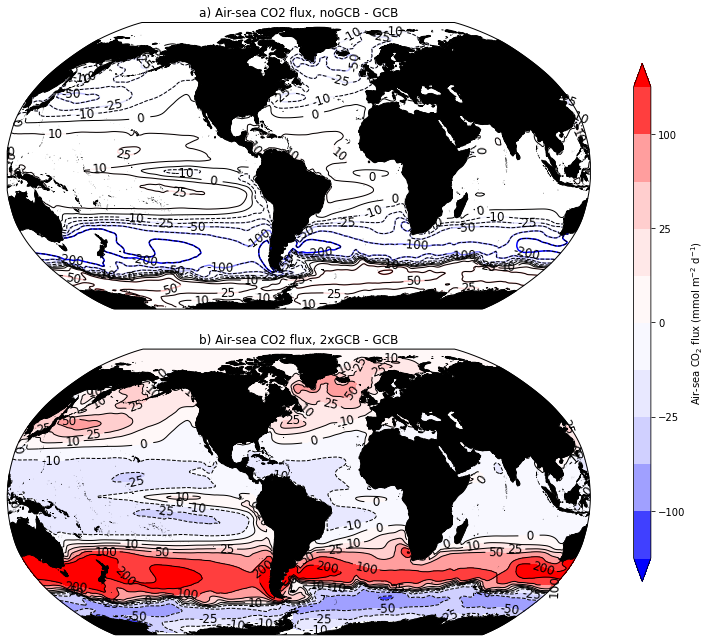

In [29]:
fig = plt.figure(figsize=(12,12))
contour_specs = {'levels': [-200.,-100.,-50.,-25.,-10.,0.,10.,25.,50., 100.,  200.]}

######### Difference in CO2 air-sea flux with NOCALC run
ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
lon,lat,field = adjust_pop_grid(lons,lats,diff_fg_co2)
ax.coastlines('10m',linewidth=0.5)
cf = ax.contour(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='bwr',extend='both',**contour_specs)

land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
                                            edgecolor='black',
                                            facecolor='black'))
ax.set_title('a) Air-sea CO2 flux, noGCB - GCB')

#overlay sigma contours
cs = ax.contour(lon,lat,field,
                colors='black',
                levels = contour_specs['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
plt.clabel(cs, colors = 'black', fmt = '%2.0f', fontsize=12)

######### Difference in CO2 air-sea flux with 2xCALC run
ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
lon,lat,field = adjust_pop_grid(lons,lats,diff_fg_co2_2x)
ax.coastlines('10m',linewidth=0.5)
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='bwr',extend='both',**contour_specs)

land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
                                            edgecolor='black',
                                            facecolor='black'))
ax.set_title('b) Air-sea CO2 flux, 2xGCB - GCB')

##overlay sigma contours
cs = ax.contour(lon,lat,field,
                colors='black',
                levels = contour_specs['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
plt.clabel(cs, colors = 'black', fmt = '%2.0f', fontsize=12)

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.21, 0.02, 0.6])
cbar = fig.colorbar(cf, cax=cbar_ax,label='Air-sea CO$_2$ flux (mmol m$^{-2}$ d$^{-1}$)',extend='max')


#fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/gas_flux.pdf', bbox_inches='tight', format='pdf');


In [30]:
0.01 * 0.001 * 12. * 1.e-15 * 864 * 365

3.784320000000001e-14

In [31]:
nmols_to_PgCyr = 1e-9 * 12. * 1e-15 * 365. * 86400.
nmols_to_PgCyr

3.784320000000001e-16

### Compute difference in global integral of CO2 flux

In [32]:
nmols_to_PgCyr = 1e-9 * 12. * 1e-15 * 365. * 86400.

In [33]:
variables = ['FG_CO2','FG_ALT_CO2']

ds_glb = xr.Dataset()
for v in variables:
    ds_glb[v] = esmlab.statistics.weighted_sum(cesm_ann_ds[v], weights=area, dim=['nlat', 'nlon'])
    ds_glb[v].attrs = cesm_ann_ds[v].attrs

    #if cesm_ann_ds[v].units == 'mmol/m^3 cm/s':
    ds_glb[v] = ds_glb[v] * nmols_to_PgCyr        
    ds_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'

ds_glb = ds_glb.compute()

In [34]:
ds_glb['FG_2xALT_CO2']=esmlab.statistics.weighted_sum(cesm_ann_ds2x[v], weights=area, dim=['nlat', 'nlon'])
ds_glb['FG_2xALT_CO2'].attrs = cesm_ann_ds2x['FG_ALT_CO2'].attrs
#if cesm_ann_ds[v].units == 'mmol/m^3 cm/s':
ds_glb['FG_2xALT_CO2'] = ds_glb['FG_2xALT_CO2'] * nmols_to_PgCyr        
ds_glb['FG_2xALT_CO2'].attrs['units'] = 'Pg C yr$^{-1}$'

In [35]:
ds_glb

<xarray.Dataset>
Dimensions:       ()
Data variables:
    FG_CO2        float64 0.1427
    FG_ALT_CO2    float64 0.2467
    FG_2xALT_CO2  float64 0.03797

### Let's look at gas flux diffs at the 400ppm CO2 extension of the run (mean over the last 10 years)

In [36]:
file = '/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.005/ocn/proc/mean_last10yr/mean_last10yr_FG_CO2.nc'
ds = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [37]:
file = '/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.005/ocn/proc/mean_last10yr/mean_last10yr_FG_ALT_CO2.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [38]:
ds['FG_CO2_noGCB'] = ds_tmp['FG_ALT_CO2']

In [39]:
file = '/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.006/ocn/proc/mean_last10yr/mean_last10yr_FG_ALT_CO2.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [40]:
ds['FG_CO2_2xGCB'] = ds_tmp['FG_ALT_CO2']

In [41]:
diff_fg_co2 = (-1. * ds.FG_CO2_noGCB) - (-1* ds.FG_CO2)
diff_fg_co2_2x = (-1. * ds.FG_CO2_2xGCB) - (-1* ds.FG_CO2)

#convert mmol/m3*cm/sec to mmol/m2/yr
convert = 0.01 * 86400. * 365.
diff_fg_co2 = diff_fg_co2 * convert
diff_fg_co2_2x = diff_fg_co2_2x * convert

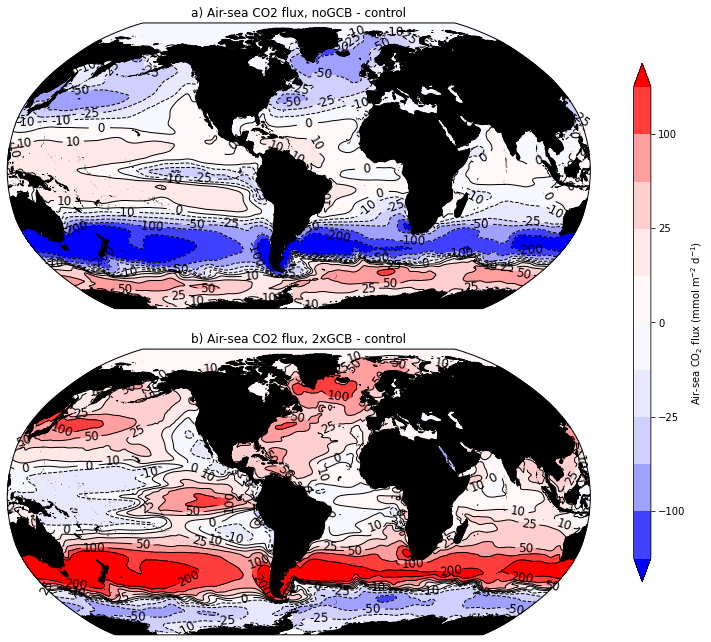

In [43]:
fig = plt.figure(figsize=(12,12))
contour_specs = {'levels': [-200.,-100.,-50.,-25.,-10.,0.,10.,25.,50., 100.,  200.]}

######### Difference in CO2 air-sea flux with NOCALC run
ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
lon,lat,field = adjust_pop_grid(lons,lats,diff_fg_co2)
ax.coastlines('10m',linewidth=0.5)
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='bwr',extend='both',**contour_specs)

land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
                                            edgecolor='black',
                                            facecolor='black'))
ax.set_title('a) Air-sea CO2 flux, noGCB - control')

#overlay sigma contours
cs = ax.contour(lon,lat,field,
                colors='black',
                levels = contour_specs['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
plt.clabel(cs, colors = 'black', fmt = '%2.0f', fontsize=12)

######### Difference in CO2 air-sea flux with 2xCALC run
ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
lon,lat,field = adjust_pop_grid(lons,lats,diff_fg_co2_2x)
ax.coastlines('10m',linewidth=0.5)
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='bwr',extend='both',**contour_specs)

land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
                                            edgecolor='black',
                                            facecolor='black'))
ax.set_title('b) Air-sea CO2 flux, 2xGCB - control')

##overlay sigma contours
cs = ax.contour(lon,lat,field,
                colors='black',
                levels = contour_specs['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
plt.clabel(cs, colors = 'black', fmt = '%2.0f', fontsize=12)

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.21, 0.02, 0.6])
cbar = fig.colorbar(cf, cax=cbar_ax,label='Air-sea CO$_2$ flux (mmol m$^{-2}$ d$^{-1}$)',extend='max')


#fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/gas_flux.pdf', bbox_inches='tight', format='pdf');


In [46]:
variables = ['FG_CO2','FG_CO2_noGCB','FG_CO2_2xGCB']

ds_glb = xr.Dataset()
for v in variables:
    ds_glb[v] = esmlab.statistics.weighted_sum(ds[v], weights=area, dim=['nlat', 'nlon'])
    ds_glb[v].attrs = ds[v].attrs

    #if cesm_ann_ds[v].units == 'mmol/m^3 cm/s':
    ds_glb[v] = ds_glb[v] * nmols_to_PgCyr        
    ds_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'

ds_glb = ds_glb.compute()

In [47]:
ds_glb

<xarray.Dataset>
Dimensions:       ()
Data variables:
    FG_CO2        float64 3.172
    FG_CO2_noGCB  float64 3.333
    FG_CO2_2xGCB  float64 2.96